# Libraries

In [1]:
!pip install gpboost -U
!pip install merf
!pip install shap

     |████████████████████████████████| 2.3 MB 2.1 MB/s eta 0:00:01


In [2]:
import random
import shap
import gpboost as gpb
import numpy as np
import scipy
import time
import copy
import pandas as pd
import matplotlib.pyplot as plt
from merf import MERF
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_friedman3
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupShuffleSplit
from tqdm.notebook import tqdm, tnrange

# Helper functions

In [3]:
def encode(df, linear=False):
    s = (df.dtypes == 'object')
    object_cols = list(s[s].index)
    if linear:
        OH_encoder = OneHotEncoder(drop='first', dtype=int)
    else:
        OH_encoder = OneHotEncoder(dtype=int)
    OH_cols = pd.DataFrame(OH_encoder.fit_transform(df[object_cols]).toarray(), columns=OH_encoder.get_feature_names(object_cols))
    num_data = df.drop(object_cols, axis=1)
    data_new = pd.concat([num_data, OH_cols], axis=1)
    return data_new

In [4]:
def train_test_split_grouped_interpolation(df, group_sizes, test_size=0.2, random_state=1):
    '''
    Train/test split, but test set contains at least one observation from each group in the training set, and contains no unseen groups.
    '''
    assert 0 < test_size < 1, "Test size must be strictly between 0 and 1"
    assert np.sum(group_sizes) == len(df), "Sum of group_sizes must be equal to length dataframe"
    assert group_sizes.all() > 0, "Group sizes should be non-negative"
    assert len(group_sizes) < len(df), "Number of groups should be less than number of observations"

    np.random.seed(random_state)
    df_len = len(df)
    test_len = int(test_size * df_len)
    no_groups = len(group_sizes)

    # Pick one observation from all groups
    sample_len = no_groups
    n_samples_chosen_per_group = np.ones_like(group_sizes)
    last_idx_arr = np.cumsum(group_sizes)-1 # Array of index of the last observation in each group within the overall dataset
    test_idx = [last_idx_arr[i] for i in range(no_groups)]
    group_sizes_new = group_sizes.copy()
    group_sizes_new -= 1

    # Keep picking more observations until the required number of test observations has been picked
    while sample_len < test_len:
        group_idx = np.random.randint(no_groups) # Pick a random group
        if group_sizes_new[group_idx] > 1:
            if test_len - sample_len > 1:
                n = np.random.randint(1, min([group_sizes_new[group_idx], test_len-sample_len])) # Pick a random sample of size 1<=n<group_size from the chosen group
            else:
                n = 1
            last_idx = last_idx_arr[group_idx]-n_samples_chosen_per_group[group_idx] # Index of the last observation remaining in each group within the overall dataset
            test_idx += [last_idx-i for i in range(n)]
            n_samples_chosen_per_group[group_idx] += n # Update number of samples chosen from the group
            group_sizes_new[group_idx] -= n # Update current group sizes
            sample_len += n

    mask = np.ones(df_len, dtype=bool)
    mask[test_idx] = False
    df_train, df_test = df[mask], df[~mask]

    return df_train, df_test

In [5]:
def train_test_split_grouped_extrapolation(df, groups, test_size=0.2, random_state=1):
    '''
    Train/test split for a dataframe, but test set only contains only unseen groups.
    ``test_size`` represents the proportion of groups to include in the test split (rounded up).
    '''
    train_idx, test_idx = next(GroupShuffleSplit(test_size=test_size, random_state=random_state).split(df, groups=groups))
    df_train, df_test = df.iloc[train_idx], df.iloc[test_idx]

    return df_train, df_test

In [6]:
def grid_search_tune_parameters_multiple(data_cv_list, dataset_list, param_grid, params=None, num_try_random=None,
                                         num_boost_round=100,
                                         use_gp_model_for_validation=True, train_gp_model_cov_pars=True,
                                         folds_list=None, nfold=5, stratified=False, shuffle=True,
                                         metrics=None, fobj=None, feval=None, init_model=None,
                                         feature_name='auto', categorical_feature='auto',
                                         early_stopping_rounds=None, fpreproc=None,
                                         verbose_eval=1, seed=0, callbacks=None,
                                         gp_model_type='Random Intercept'):
    '''
    Conducts grid search over a list of training sets.
    '''
    # Check correct format
    if not isinstance(param_grid, dict):
        raise ValueError('param_grid needs to be a dict')
    if verbose_eval is None:
        verbose_eval = 0
    else:
        if not isinstance(verbose_eval, int):
            raise ValueError('verbose_eval needs to be int')
    if params is None:
        params = {}
    else:
        params = copy.deepcopy(params)
    param_grid = copy.deepcopy(param_grid)
    for param in param_grid:
        if gpb.basic.is_numeric(param_grid[param]):
            param_grid[param] = [param_grid[param]]
        param_grid[param] = gpb.basic._format_check_1D_data(param_grid[param],
                                                  data_name=param, check_data_type=False,
                                                  check_must_be_int=False, convert_to_type=None)

    # Determine combinations of parameter values that should be tried out
    grid_size = gpb.engine._get_grid_size(param_grid)
    if num_try_random is not None:
        if num_try_random > grid_size:
            raise ValueError('num_try_random is larger than the number of all possible combinations of parameters in param_grid')
        try_param_combs = np.random.RandomState(seed).choice(a=grid_size, size=num_try_random, replace=False)
        print('Starting random grid search with ' + str(num_try_random) + ' trials out of ' + str(grid_size) + ' parameter combinations...')
    else:
        try_param_combs = range(grid_size)
        print('Starting deterministic grid search with ' + str(grid_size) + ' parameter combinations...')
    if verbose_eval < 2:
        verbose_eval_cv = False
    else:
        verbose_eval_cv = True

    best_score = 1e99
    current_score = 1e99
    best_params = {}
    best_num_boost_round = num_boost_round
    counter_num_comb = 1
    for param_comb_number in try_param_combs:
        cvbst_list = []
        param_comb = gpb.engine._get_param_combination(param_comb_number=param_comb_number, param_grid=param_grid)
        for param in param_comb:
            params[param] = param_comb[param]
        if verbose_eval >= 1:
            print('Trying parameter combination ' + str(counter_num_comb) +
                  ' of ' + str(len(try_param_combs)) + ': ' + str(param_comb) + ' ...')
        for i, dataset in enumerate(dataset_list):
            folds = [folds_list[i]]
            if gp_model_type == 'Random Intercept':
                gp_model = gpb.GPModel(group_data=np.column_stack((data_cv_list[i]['ID'], data_cv_list[i]['times'])))
            elif gp_model_type == 'Individual GP':
                gp_model = gpb.GPModel(group_data=data_cv_list[i]['ID'], gp_coords=data_cv_list[i]['times'], cluster_ids=data_cv_list[i]['ID'], cov_function='exponential')
            else:
                raise Exception(gp_model_type is invalid)
            gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'use_nesterov_acc': True})
            cvbst = gpb.cv(params=params, train_set=dataset, num_boost_round=num_boost_round,
                        gp_model=gp_model, use_gp_model_for_validation=use_gp_model_for_validation,
                        train_gp_model_cov_pars=train_gp_model_cov_pars,
                        folds=folds, nfold=nfold, stratified=stratified, shuffle=shuffle,
                        metrics=metrics, fobj=fobj, feval=feval, init_model=init_model,
                        feature_name=feature_name, categorical_feature=categorical_feature,
                        early_stopping_rounds=early_stopping_rounds, fpreproc=fpreproc,
                        verbose_eval=verbose_eval_cv, seed=seed, callbacks=callbacks,
                        eval_train_metric=False, return_cvbooster=False)
            cvbst_list.append(cvbst)
        current_score_is_better = False
        current_score = np.mean([np.min(cvbst[next(iter(cvbst))]) for cvbst in cvbst_list])
        if current_score < best_score:
            current_score_is_better = True
        if current_score_is_better:
            best_score = current_score
            best_params = param_comb
            best_num_boost_round = np.mean([np.argmin(cvbst[next(iter(cvbst))]) for cvbst in cvbst_list])
            if verbose_eval >= 1:
                print('***** New best score (' + str(best_score) + ') found for the following parameter combination:')
                best_params_print = copy.deepcopy(best_params)
                best_params_print['num_boost_round'] = best_num_boost_round
                print(best_params_print)
        counter_num_comb = counter_num_comb + 1

    return {'best_params': best_params, 'best_iter': best_num_boost_round, 'best_score': best_score}

In [7]:
# Create a function to do CV with MERF
def MERF_cv(train_X_list, train_y_list, val_X_list, val_y_list, random_state=1):
    n_estimators_list = [100, 200, 300]
    accuracies = []
    for n_estimators in tqdm(n_estimators_list):
        fixed_effects_model= RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, random_state=random_state)
        model_accuracies = []
        for i in range(len(train_X_list)):
            train_X = train_X_list[i].drop(columns=['ID', 'times', 'egfr']).to_numpy()
            train_Z = train_X_list[i]['times'].to_numpy()
            train_group = train_X_list[i]['ID'].to_numpy()
            train_y = train_y_list[i]
            val_X = val_X_list[i].drop(columns=['ID', 'times', 'egfr']).to_numpy()
            val_Z = val_X_list[i]['times'].to_numpy()
            val_group = val_X_list[i]['ID'].to_numpy()
            val_y = val_y_list[i]
            merf_model = MERF(fixed_effects_model, max_iterations=100)
            merf_model.fit(train_X, train_Z, pd.Series(train_group), train_y)
            y_pred = merf_model.predict(val_X, val_Z, pd.Series(val_group))
            model_accuracies.append(np.sqrt(np.mean((val_y-y_pred)**2)))
        accuracies.append(np.mean(model_accuracies))

    return np.array(accuracies)

# Data pre-processing

In [8]:
data_train_full_raw = pd.read_csv('data_train_full.csv')
test_extrapolation_raw = pd.read_csv('test_extrapolation.csv')
test_interpolation_raw = pd.read_csv('test_interpolation.csv')

# One-hot encode categorical features
data_train_full = encode(data_train_full_raw)
test_extrapolation = encode(test_extrapolation_raw)
test_interpolation = encode(test_interpolation_raw)

# Dummy encode categorical features for linear model
data_train_full2 = encode(data_train_full_raw, linear=True)
test_extrapolation2 = encode(test_extrapolation_raw, linear=True)
test_interpolation2 = encode(test_interpolation_raw, linear=True)

data_train_list, data_val_list = [], []
for i in range(5):
    train_raw = pd.read_csv('data_cv_train_' + str(i+1) + '.csv')
    train = encode(train_raw)
    val_raw = pd.read_csv('data_cv_val_' + str(i+1) + '.csv')
    val = encode(val_raw)
    data_train_list.append(train)
    data_val_list.append(val)

data_cv_list = [pd.concat([data_train_list[i], data_val_list[i]], ignore_index=True).reset_index(drop=True).fillna(0) for i in range(5)]

In [9]:
# Get indices of training and validation sets for cross-validation
data_cv_indices_list = []
for i in range(5):
    data_cv_indices_list.append((np.arange(len(data_train_list[i])), np.arange(len(data_train_list[i]), len(data_train_list[i])+len(data_val_list[i]))))

print(data_cv_indices_list)

[(array([   0,    1,    2, ..., 4895, 4896, 4897]), array([4898, 4899, 4900, ..., 6120, 6121, 6122])), (array([   0,    1,    2, ..., 4895, 4896, 4897]), array([4898, 4899, 4900, ..., 6120, 6121, 6122])), (array([   0,    1,    2, ..., 4895, 4896, 4897]), array([4898, 4899, 4900, ..., 6120, 6121, 6122])), (array([   0,    1,    2, ..., 4896, 4897, 4898]), array([4899, 4900, 4901, ..., 6120, 6121, 6122])), (array([   0,    1,    2, ..., 4896, 4897, 4898]), array([4899, 4900, 4901, ..., 6120, 6121, 6122]))]


In [10]:
# Train/test split
train_X, train_y = data_train_full.drop(columns=['egfr']), data_train_full['egfr'].to_numpy()
test_extrapolation_X, test_extrapolation_y = test_extrapolation.drop(columns=['egfr']), test_extrapolation['egfr'].to_numpy()
test_interpolation_X, test_interpolation_y = test_interpolation.drop(columns=['egfr']), test_interpolation['egfr'].to_numpy()
data_train_full_gpb = gpb.Dataset(data=train_X.drop(columns=['ID', 'times']), label=train_y)

# For linear
train_X2 = data_train_full2.drop(columns=['egfr'])
test_extrapolation_X2 = test_extrapolation2.drop(columns=['egfr'])
test_interpolation_X2 = test_interpolation2.drop(columns=['egfr'])
data_train_full2_gpb = gpb.Dataset(data=train_X2.drop(columns=['ID', 'times']), label=train_y)

# CV sets
dataset_list = []
for i in range(5):
    cv_train_X, cv_train_y = data_cv_list[i].drop(columns=['egfr']), data_cv_list[i]['egfr'].to_numpy()
    dataset_list.append(gpb.Dataset(data=cv_train_X.drop(columns=['ID', 'times']), label=cv_train_y))

In [11]:
data_train_full

,ID,age,height,weight,kidney_transplant,patient_died,bp.sys,bun,egfr,times,site_Patras,site_Sheffield,gender_Female,gender_Male,gender_Unknown,ethnicity_Asian,ethnicity_Black,ethnicity_Caucasian,ethnicity_Others,ethnicity_Unknown,smoker_Non-Smoker,smoker_Past-Smoker,smoker_Smoker,smoker_Unknown,disease_DN,disease_GMN,disease_HTN,disease_Obstructive,disease_Other,disease_Transplant,disease_Vascular
0,0,59.0,1.69,132.2,False,False,150.600000,8.0,73.0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
1,0,59.0,1.69,132.2,False,False,143.000000,8.0,62.0,168,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
2,0,59.0,1.69,132.2,False,False,150.000000,6.0,74.0,294,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
3,0,60.0,1.69,132.2,False,False,138.000000,7.0,77.0,492,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
4,0,60.0,1.69,132.2,False,False,144.000000,7.0,70.0,608,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6118,1366,37.0,1.78,68.0,True,False,118.333333,46.0,66.0,275,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
6119,1366,37.0,1.78,68.0,True,False,120.000000,63.0,61.0,359,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
6120,1366,37.0,1.78,68.0,True,False,118.333333,39.0,66.0,473,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
6121,1366,37.0,1.78,68.0,True,False,120.000000,45.0,61.0,535,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0


# Analysis

## Hyperparameter tuning for GPBoost

### Random Intercept

In [ ]:
# Candidate parameter grid
param_grid = {'learning_rate': [0.5, 0.8, 1.0, 1.2, 1.5], 
              'max_depth': [1, 5, 10],
              'min_data_in_leaf': [10, 50, 100]}

# Other parameters not contained in the grid of tuning parameters
params = {'objective': 'regression_l2', 'verbose': 0, 'num_leaves': 2**10}
opt_params = grid_search_tune_parameters_multiple(data_cv_list=data_cv_list,
                                                  dataset_list=dataset_list,
                                                  param_grid=param_grid,
                                                  params=params,
                                                  folds_list=data_cv_indices_list,
                                                  use_gp_model_for_validation=True,
                                                  verbose_eval=1,
                                                  num_boost_round=4000, 
                                                  early_stopping_rounds=10,
                                                  shuffle=False,
                                                  seed=1,
                                                  metrics='rmse',
                                                  gp_model_type='Random Intercept')
print('Best number of iterations: ', opt_params['best_iter'])
print('Best score: ', opt_params['best_score'])
print('Best parameters: ', opt_params['best_params'])

Starting deterministic grid search with 45 parameter combinations...
Trying parameter combination 1 of 45: {'learning_rate': 0.5, 'max_depth': 1, 'min_data_in_leaf': 10} ...
***** New best score (23.927823484778695) found for the following parameter combination:
{'learning_rate': 0.5, 'max_depth': 1, 'min_data_in_leaf': 10, 'num_boost_round': 1037.2}
Trying parameter combination 2 of 45: {'learning_rate': 0.8, 'max_depth': 1, 'min_data_in_leaf': 10} ...
***** New best score (23.924610422856738) found for the following parameter combination:
{'learning_rate': 0.8, 'max_depth': 1, 'min_data_in_leaf': 10, 'num_boost_round': 690.0}
Trying parameter combination 3 of 45: {'learning_rate': 1.0, 'max_depth': 1, 'min_data_in_leaf': 10} ...
Trying parameter combination 4 of 45: {'learning_rate': 1.2, 'max_depth': 1, 'min_data_in_leaf': 10} ...
***** New best score (23.924079555485964) found for the following parameter combination:
{'learning_rate': 1.2, 'max_depth': 1, 'min_data_in_leaf': 10, 'n

### Independent GP

In [ ]:
# Candidate parameter grid
param_grid = {'learning_rate': [0.8, 1, 1.2], 
              'max_depth': [1, 5, 10],
              'min_data_in_leaf': [10, 50, 100]}

# Other parameters not contained in the grid of tuning parameters
params = {'objective': 'regression_l2', 'verbose': 0, 'num_leaves': 2**10}
opt_params = grid_search_tune_parameters_multiple(data_cv_list=data_cv_list,
                                                  dataset_list=dataset_list,
                                                  param_grid=param_grid,
                                                  params=params,
                                                  folds_list=data_cv_indices_list,
                                                  use_gp_model_for_validation=True,
                                                  verbose_eval=1,
                                                  num_boost_round=4000, 
                                                  early_stopping_rounds=10,
                                                  shuffle=False,
                                                  seed=1,
                                                  metrics='rmse',
                                                  gp_model_type='Individual GP')
print('Best number of iterations: ', opt_params['best_iter'])
print('Best score: ', opt_params['best_score'])
print('Best parameters: ', opt_params['best_params'])

Starting deterministic grid search with 27 parameter combinations...
Trying parameter combination 1 of 27: {'learning_rate': 0.8, 'max_depth': 1, 'min_data_in_leaf': 10} ...
***** New best score (23.884840634963826) found for the following parameter combination:
{'learning_rate': 0.8, 'max_depth': 1, 'min_data_in_leaf': 10, 'num_boost_round': 789.8}
Trying parameter combination 2 of 27: {'learning_rate': 1.0, 'max_depth': 1, 'min_data_in_leaf': 10} ...
***** New best score (23.88305850275598) found for the following parameter combination:
{'learning_rate': 1.0, 'max_depth': 1, 'min_data_in_leaf': 10, 'num_boost_round': 647.8}
Trying parameter combination 3 of 27: {'learning_rate': 1.2, 'max_depth': 1, 'min_data_in_leaf': 10} ...
***** New best score (23.88263448387105) found for the following parameter combination:
{'learning_rate': 1.2, 'max_depth': 1, 'min_data_in_leaf': 10, 'num_boost_round': 542.2}
Trying parameter combination 4 of 27: {'learning_rate': 0.8, 'max_depth': 5, 'min_da

## Comparison of models

In [12]:
# Create results dataframe
results = pd.DataFrame(columns=['RMSE_extrapolation', 'RMSE_interpolation', 'Time'],
                       index=['Linear Mixed Effects Model with no fixed features (random intercept)',
                              'Linear Mixed Effects Model with Random Intercept',
                              'Linear Mixed Effects Model with Shared Gaussian Process',
                              'Linear Mixed Effects Model with Individual Gaussian Process',
                              'MERF',
                              'GPBoost with Random Intercept',
                              'GPBoost with Shared Gaussian Process',
                              'GPBoost with Individual Gaussian Process'])

In [13]:
train_X_features = train_X.drop(columns=['ID', 'times'])
test_extrapolation_X_features = test_extrapolation_X.drop(columns=['ID', 'times'])
test_interpolation_X_features = test_interpolation_X.drop(columns=['ID', 'times'])

train_X2_features = train_X2.drop(columns=['ID', 'times'])
test_extrapolation_X2_features = test_extrapolation_X2.drop(columns=['ID', 'times'])
test_interpolation_X2_features = test_interpolation_X2.drop(columns=['ID', 'times'])
train_X2_linear = np.column_stack((np.ones(len(train_X2_features)), train_X2_features))
test_extrapolation_X2_linear = np.column_stack((np.ones(len(test_extrapolation_X2_features)), test_extrapolation_X2_features))
test_interpolation_X2_linear = np.column_stack((np.ones(len(test_interpolation_X2_features)), test_interpolation_X2_features))

train_Z = np.column_stack((np.ones(len(train_X)), train_X['times']))
test_extrapolation_Z = np.column_stack((np.ones(len(test_extrapolation_X)), test_extrapolation_X['times']))
test_interpolation_Z = np.column_stack((np.ones(len(test_interpolation_X)), test_interpolation_X['times']))

In [ ]:
# 1. Linear Mixed Effects Model with no fixed features (random intercept)
np.random.seed(1)
model = gpb.GPModel(group_data=np.column_stack((train_X2['ID'], train_X2['times'])))
model.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'use_nesterov_acc': True})

start_time = time.time()
model.fit(y=train_y, X=np.ones(len(train_X2)))
results.loc['Linear Mixed Effects Model with no fixed features (random intercept)', 'Time'] = time.time() - start_time
y_pred_extrapolation = model.predict(group_data_pred=np.column_stack((test_extrapolation_X2['ID'], test_extrapolation_X2['times'])),
                                     X_pred=np.ones(len(test_extrapolation_X2)))
results.loc['Linear Mixed Effects Model with no fixed features (random intercept)', 'RMSE_extrapolation'] = np.sqrt(np.mean((test_extrapolation_y-y_pred_extrapolation['mu'])**2))
y_pred_interpolation = model.predict(group_data_pred=np.column_stack((test_interpolation_X2['ID'], test_interpolation_X2['times'])),
                                     X_pred=np.ones(len(test_interpolation_X2)))
results.loc['Linear Mixed Effects Model with no fixed features (random intercept)', 'RMSE_interpolation'] = np.sqrt(np.mean((test_interpolation_y-y_pred_interpolation['mu'])**2))

In [ ]:
# 2. Linear Mixed Effects Model with Random Intercept
np.random.seed(1)
model = gpb.GPModel(group_data=np.column_stack((train_X2['ID'], train_X2['times'])))
model.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'use_nesterov_acc': True})

start_time = time.time()
model.fit(y=train_y, X=train_X2_linear)
results.loc['Linear Mixed Effects Model with Random Intercept', 'Time'] = time.time() - start_time
y_pred_extrapolation = model.predict(group_data_pred=np.column_stack((test_extrapolation_X2['ID'], test_extrapolation_X2['times'])),
                                     X_pred=test_extrapolation_X2_linear)
results.loc['Linear Mixed Effects Model with Random Intercept', 'RMSE_extrapolation'] = np.sqrt(np.mean((test_extrapolation_y-y_pred_extrapolation['mu'])**2))
y_pred_interpolation = model.predict(group_data_pred=np.column_stack((test_interpolation_X2['ID'], test_interpolation_X2['times'])),
                                     X_pred=test_interpolation_X2_linear)
results.loc['Linear Mixed Effects Model with Random Intercept', 'RMSE_interpolation'] = np.sqrt(np.mean((test_interpolation_y-y_pred_interpolation['mu'])**2))

In [ ]:
# 3. Linear Mixed Effects Model with Shared Gaussian Process
np.random.seed(1)
model = gpb.GPModel(group_data=train_X2['ID'], gp_coords=train_X2['times'], cov_function='exponential')
model.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'use_nesterov_acc': True})

start_time = time.time()
model.fit(y=train_y, X=train_X2_linear)
results.loc['Linear Mixed Effects Model with Shared Gaussian Process', 'Time'] = time.time() - start_time
y_pred_extrapolation = model.predict(group_data_pred=test_extrapolation_X2['ID'],
                                     gp_coords_pred=test_extrapolation_X2['times'],
                                     X_pred=test_extrapolation_X2_linear)
results.loc['Linear Mixed Effects Model with Shared Gaussian Process', 'RMSE_extrapolation'] = np.sqrt(np.mean((test_extrapolation_y-y_pred_extrapolation['mu'])**2))
y_pred_interpolation = model.predict(group_data_pred=test_interpolation_X2['ID'],
                                     gp_coords_pred=test_interpolation_X2['times'],
                                     X_pred=test_interpolation_X2_linear)
results.loc['Linear Mixed Effects Model with Shared Gaussian Process', 'RMSE_interpolation'] = np.sqrt(np.mean((test_interpolation_y-y_pred_interpolation['mu'])**2))

In [ ]:
# 4. Linear Mixed Effects Model with Individual Gaussian Process
np.random.seed(1)
model = gpb.GPModel(group_data=train_X2['ID'], gp_coords=train_X2['times'], cluster_ids=train_X2['ID'], cov_function='exponential')
model.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'use_nesterov_acc': True})

start_time = time.time()
model.fit(y=train_y, X=train_X2_linear)
results.loc['Linear Mixed Effects Model with Individual Gaussian Process', 'Time'] = time.time() - start_time
y_pred_extrapolation = model.predict(group_data_pred=test_extrapolation_X2['ID'],
                                     gp_coords_pred=test_extrapolation_X2['times'],
                                     cluster_ids_pred=test_extrapolation_X2['ID'],
                                     X_pred=test_extrapolation_X2_linear)
results.loc['Linear Mixed Effects Model with Individual Gaussian Process', 'RMSE_extrapolation'] = np.sqrt(np.mean((test_extrapolation_y-y_pred_extrapolation['mu'])**2))
y_pred_interpolation = model.predict(group_data_pred=test_interpolation_X2['ID'],
                                     gp_coords_pred=test_interpolation_X2['times'],
                                     cluster_ids_pred=test_interpolation_X2['ID'],
                                     X_pred=test_interpolation_X2_linear)
results.loc['Linear Mixed Effects Model with Individual Gaussian Process', 'RMSE_interpolation'] = np.sqrt(np.mean((test_interpolation_y-y_pred_interpolation['mu'])**2))

In [ ]:
# 5. MERF
np.random.seed(1)
fixed_effects_model= RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=1)
merf_model = MERF(fixed_effects_model, max_iterations=30)

start_time = time.time()
merf_model.fit(train_X_features, train_Z, train_X['ID'], train_y)
results.loc['MERF', 'Time'] = time.time() - start_time
y_pred_extrapolation = merf_model.predict(test_extrapolation_X_features, test_extrapolation_Z, test_extrapolation_X['ID'])
results.loc['MERF', 'RMSE_extrapolation'] = np.sqrt(np.mean((test_extrapolation_y-y_pred_extrapolation)**2))
y_pred_interpolation = merf_model.predict(test_interpolation_X_features, test_interpolation_Z, test_interpolation_X['ID'])
results.loc['MERF', 'RMSE_interpolation'] = np.sqrt(np.mean((test_interpolation_y-y_pred_interpolation)**2))

In [ ]:
# 6. GPBoost with Random Intercept
np.random.seed(1)
gp_model = gpb.GPModel(group_data=np.column_stack((train_X['ID'], train_X['times'])))
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'use_nesterov_acc': True})
params = {'objective': 'regression_l2',
          'learning_rate': 1.5,
          'max_depth': 5,
          'min_data_in_leaf': 100,
          'verbose': 0}

start_time = time.time()
bst = gpb.train(params=params,
                train_set=data_train_full_gpb,
                gp_model=gp_model,
                num_boost_round=1847)
results.loc['GPBoost with Random Intercept', 'Time'] = time.time() - start_time
pred_extrapolation = bst.predict(data=test_extrapolation_X_features, group_data_pred=np.column_stack((test_extrapolation_X['ID'], test_extrapolation_X['times'])))
y_pred_extrapolation = pred_extrapolation['fixed_effect'] + pred_extrapolation['random_effect_mean']
results.loc['GPBoost with Random Intercept', 'RMSE_extrapolation'] = np.sqrt(np.mean((test_extrapolation_y-y_pred_extrapolation)**2))
pred_interpolation = bst.predict(data=test_interpolation_X_features, group_data_pred=np.column_stack((test_interpolation_X['ID'], test_interpolation_X['times'])))
y_pred_interpolation = pred_interpolation['fixed_effect'] + pred_interpolation['random_effect_mean']
results.loc['GPBoost with Random Intercept', 'RMSE_interpolation'] = np.sqrt(np.mean((test_interpolation_y-y_pred_interpolation)**2))

In [ ]:
# 7. GPBoost with Shared Gaussian Process
np.random.seed(1)
gp_model = gpb.GPModel(group_data=train_X['ID'], gp_coords=train_X['times'])
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'use_nesterov_acc': True})
params = {'objective': 'regression_l2',
          'learning_rate': 1.2,
          'max_depth': 5,
          'min_data_in_leaf': 100,
          'verbose': 0}

start_time = time.time()
bst = gpb.train(params=params,
                train_set=data_train_full_gpb,
                gp_model=gp_model,
                num_boost_round=2343)
results.loc['GPBoost with Shared Gaussian Process', 'Time'] = time.time() - start_time
pred_extrapolation = bst.predict(data=test_extrapolation_X_features,
                                 group_data_pred=test_extrapolation_X['ID'],
                                 gp_coords_pred=test_extrapolation_X['times'])
y_pred_extrapolation = pred_extrapolation['fixed_effect'] + pred_extrapolation['random_effect_mean']
results.loc['GPBoost with Shared Gaussian Process', 'RMSE_extrapolation'] = np.sqrt(np.mean((test_extrapolation_y-y_pred_extrapolation)**2))
pred_interpolation = bst.predict(data=test_interpolation_X_features,
                                 group_data_pred=test_interpolation_X['ID'],
                                 gp_coords_pred=test_interpolation_X['times'])
y_pred_interpolation = pred_interpolation['fixed_effect'] + pred_interpolation['random_effect_mean']
results.loc['GPBoost with Shared Gaussian Process', 'RMSE_interpolation'] = np.sqrt(np.mean((test_interpolation_y-y_pred_interpolation)**2))

In [14]:
# 8. GPBoost with Individual Gaussian Process
np.random.seed(1)
gp_model = gpb.GPModel(group_data=train_X['ID'], gp_coords=train_X['times'], cluster_ids=train_X['ID'])
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'use_nesterov_acc': True})
params = {'objective': 'regression_l2',
          'learning_rate': 1.2,
          'max_depth': 5,
          'min_data_in_leaf': 100,
          'verbose': 0}

start_time = time.time()
bst = gpb.train(params=params,
                train_set=data_train_full_gpb,
                gp_model=gp_model,
                num_boost_round=2343)
results.loc['GPBoost with Individual Gaussian Process', 'Time'] = time.time() - start_time
pred_extrapolation = bst.predict(data=test_extrapolation_X_features,
                                 group_data_pred=test_extrapolation_X['ID'],
                                 gp_coords_pred=test_extrapolation_X['times'],
                                 cluster_ids_pred=test_extrapolation_X['ID'])
y_pred_extrapolation = pred_extrapolation['fixed_effect'] + pred_extrapolation['random_effect_mean']
results.loc['GPBoost with Individual Gaussian Process', 'RMSE_extrapolation'] = np.sqrt(np.mean((test_extrapolation_y-y_pred_extrapolation)**2))
pred_interpolation = bst.predict(data=test_interpolation_X_features,
                                 group_data_pred=test_interpolation_X['ID'],
                                 gp_coords_pred=test_interpolation_X['times'],
                                 cluster_ids_pred=test_interpolation_X['ID'])
y_pred_interpolation = pred_interpolation['fixed_effect'] + pred_interpolation['random_effect_mean']
results.loc['GPBoost with Individual Gaussian Process', 'RMSE_interpolation'] = np.sqrt(np.mean((test_interpolation_y-y_pred_interpolation)**2))

In [ ]:
results

,RMSE_extrapolation,RMSE_interpolation,Time
Linear Mixed Effects Model with no fixed features (random intercept),26.4524,12.8361,10.296
Linear Mixed Effects Model with Random Intercept,20.527,11.7726,2.07577
Linear Mixed Effects Model with Shared Gaussian Process,NaN,NaN,NaN
Linear Mixed Effects Model with Individual Gaussian Process,NaN,NaN,NaN
MERF,NaN,NaN,NaN
GPBoost with Random Intercept,19.2385,10.7464,622.12
GPBoost with Shared Gaussian Process,NaN,NaN,NaN
GPBoost with Individual Gaussian Process,NaN,NaN,NaN


# Feature importance

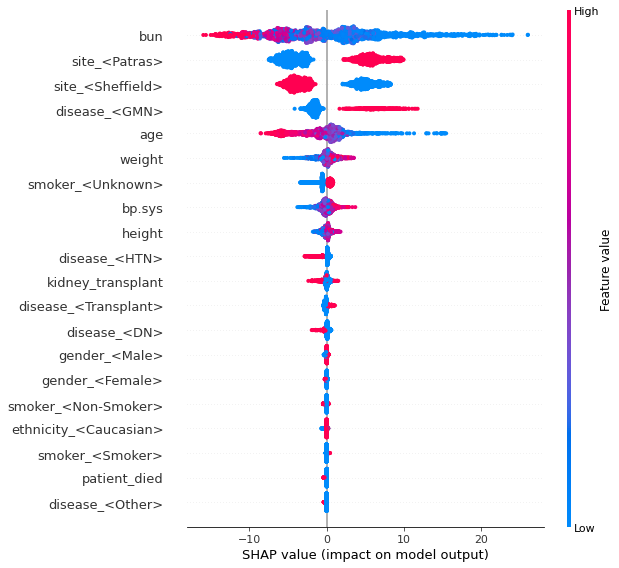

In [ ]:
# Extrapolation test set
shap_values = shap.TreeExplainer(bst).shap_values(test_extrapolation_X_features)
shap.summary_plot(shap_values, test_extrapolation_X_features)

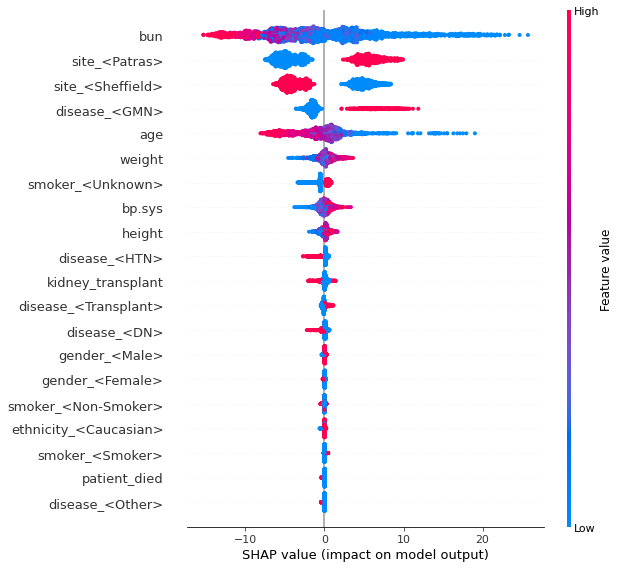

In [ ]:
# Interpolation test set
shap_values = shap.TreeExplainer(bst).shap_values(test_interpolation_X_features)
shap.summary_plot(shap_values, test_interpolation_X_features)

# MERF Analysis

In [ ]:
RMSE_extrapolation_list_mean = []
RMSE_interpolation_list_mean = []
RMSE_extrapolation_list_std = []
RMSE_interpolation_list_std = []
iterations_list = [10, 30, 50, 80, 100]
for i in tqdm(iterations_list):
    np.random.seed(1)
    RMSE_extrapolation_list = []
    RMSE_interpolation_list = []
    for j in range(5):
        fixed_effects_model= RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=1)
        merf_model = MERF(fixed_effects_model, max_iterations=i)
        merf_model.fit(train_X_features, train_Z, train_X['ID'], train_y)
        y_pred_extrapolation = merf_model.predict(test_extrapolation_X_features, test_extrapolation_Z, test_extrapolation_X['ID'])
        RMSE_extrapolation_list.append(np.sqrt(np.mean((test_extrapolation_y-y_pred_extrapolation)**2)))
        y_pred_interpolation = merf_model.predict(test_interpolation_X_features, test_interpolation_Z, test_interpolation_X['ID'])
        RMSE_interpolation_list.append(np.sqrt(np.mean((test_interpolation_y-y_pred_interpolation)**2)))
    RMSE_extrapolation_list_mean.append(np.mean(RMSE_extrapolation_list))
    RMSE_interpolation_list_mean.append(np.mean(RMSE_interpolation_list))
    RMSE_extrapolation_list_std.append(np.std(RMSE_extrapolation_list))
    RMSE_interpolation_list_std.append(np.std(RMSE_interpolation_list))

In [ ]:
MERF_results_mean = pd.DataFrame(data={'RMSE_extrapolation': RMSE_extrapolation_list_mean,
                                       'RMSE_interpolation': RMSE_interpolation_list_mean},
                                 index=iterations_list)
MERF_results_std = pd.DataFrame(data={'RMSE_extrapolation': RMSE_extrapolation_list_std,
                                       'RMSE_interpolation': RMSE_interpolation_list_std},
                                index=iterations_list)

<Figure size 432x288 with 0 Axes>

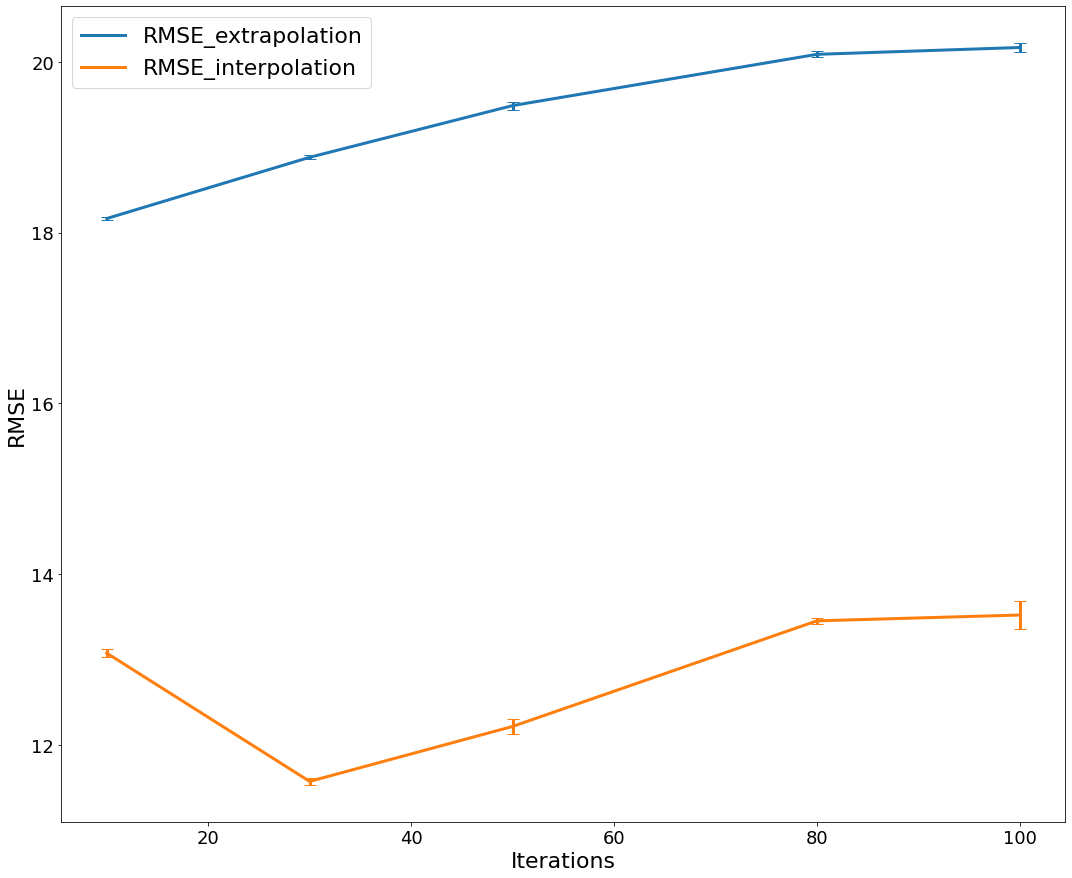

In [ ]:
plt.figure()
ax = MERF_results_mean.plot(figsize=(18, 15), xlabel='Iterations', ylabel='RMSE', style='o-', fontsize=18, lw=3, yerr=MERF_results_std, capsize=6)
plt.rcParams.update({'font.size': 22})
plt.show()

# Show Patient GP

In [ ]:
np.random.seed(1)
gp_model = gpb.GPModel(group_data=train_X['ID'], gp_coords=train_X['times'], cluster_ids=train_X['ID'])
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'use_nesterov_acc': True})
params = {'objective': 'regression_l2',
          'learning_rate': 1.2,
          'max_depth': 5,
          'min_data_in_leaf': 100,
          'verbose': 0}

start_time = time.time()
bst = gpb.train(params=params,
                train_set=data_train_full_gpb,
                gp_model=gp_model,
                num_boost_round=2343)

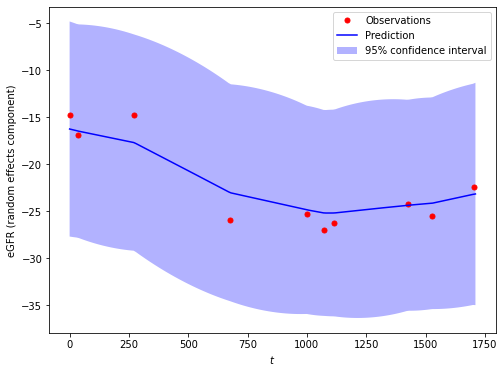

In [88]:
single_patient_data = data_train_full[data_train_full['ID'] == 41]
y_true = single_patient_data['egfr'].to_numpy()
predictions = bst.predict(data=single_patient_data.drop(columns=['egfr', 'ID', 'times']), 
                          group_data_pred=single_patient_data['ID'],
                          gp_coords_pred=single_patient_data['times'],
                          cluster_ids_pred=single_patient_data['ID'],
                          predict_var=True)
points = np.arange(single_patient_data['times'].iloc[-1]+10, step=10)
p = np.tile(single_patient_data['ID'].iloc[0], len(points))
predictions_points = gp_model.predict(group_data_pred=p, gp_coords_pred=points, cluster_ids_pred=p, predict_var=True)
sigma = np.sqrt(predictions_points['var'])
plt.figure(figsize=(8,6))
plt.plot(single_patient_data['times'], y_true-predictions['fixed_effect'], 'r.', markersize=10, label='Observations')
plt.plot(points, predictions_points['mu'], 'b-', label='Prediction')
plt.fill_between(points, predictions_points['mu'] - 1.96 * sigma,
                 predictions_points['mu'] + 1.96 * sigma, alpha=0.3,
                 fc='b', label='95% confidence interval')
plt.xlabel('$t$')
plt.ylabel('eGFR (random effects component)')
plt.legend(loc='upper right')
plt.show()

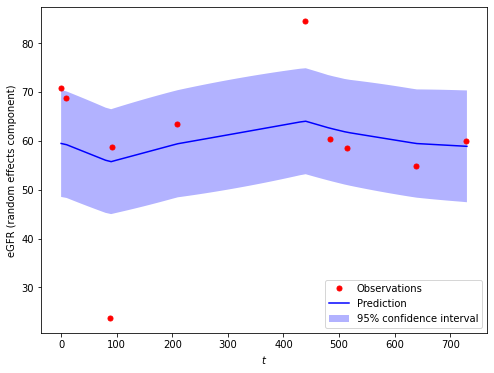

In [89]:
single_patient_data = data_train_full[data_train_full['ID'] == 5]
y_true = single_patient_data['egfr'].to_numpy()
predictions = bst.predict(data=single_patient_data.drop(columns=['egfr', 'ID', 'times']), 
                          group_data_pred=single_patient_data['ID'],
                          gp_coords_pred=single_patient_data['times'],
                          cluster_ids_pred=single_patient_data['ID'],
                          predict_var=True)
points = np.arange(single_patient_data['times'].iloc[-1]+10, step=10)
p = np.tile(single_patient_data['ID'].iloc[0], len(points))
predictions_points = gp_model.predict(group_data_pred=p, gp_coords_pred=points, cluster_ids_pred=p, predict_var=True)
sigma = np.sqrt(predictions_points['var'])
plt.figure(figsize=(8,6))
plt.plot(single_patient_data['times'], y_true-predictions['fixed_effect'], 'r.', markersize=10, label='Observations')
plt.plot(points, predictions_points['mu'], 'b-', label='Prediction')
plt.fill_between(points, predictions_points['mu'] - 1.96 * sigma,
                 predictions_points['mu'] + 1.96 * sigma, alpha=0.3,
                 fc='b', label='95% confidence interval')
plt.xlabel('$t$')
plt.ylabel('eGFR (random effects component)')
plt.legend(loc='lower right')
plt.show()

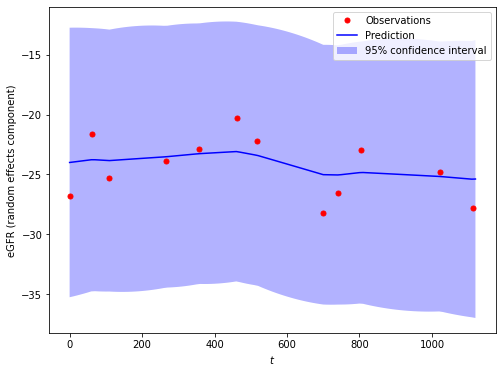

In [90]:
single_patient_data = data_train_full[data_train_full['ID'] == 727]
y_true = single_patient_data['egfr'].to_numpy()
predictions = bst.predict(data=single_patient_data.drop(columns=['egfr', 'ID', 'times']), 
                          group_data_pred=single_patient_data['ID'],
                          gp_coords_pred=single_patient_data['times'],
                          cluster_ids_pred=single_patient_data['ID'],
                          predict_var=True)
points = np.arange(single_patient_data['times'].iloc[-1]+10, step=10)
p = np.tile(single_patient_data['ID'].iloc[0], len(points))
predictions_points = gp_model.predict(group_data_pred=p, gp_coords_pred=points, cluster_ids_pred=p, predict_var=True)
sigma = np.sqrt(predictions_points['var'])
plt.figure(figsize=(8,6))
plt.plot(single_patient_data['times'], y_true-predictions['fixed_effect'], 'r.', markersize=10, label='Observations')
plt.plot(points, predictions_points['mu'], 'b-', label='Prediction')
plt.fill_between(points, predictions_points['mu'] - 1.96 * sigma,
                 predictions_points['mu'] + 1.96 * sigma, alpha=0.3,
                 fc='b', label='95% confidence interval')
plt.xlabel('$t$')
plt.ylabel('eGFR (random effects component)')
plt.legend(loc='upper right')
plt.show()

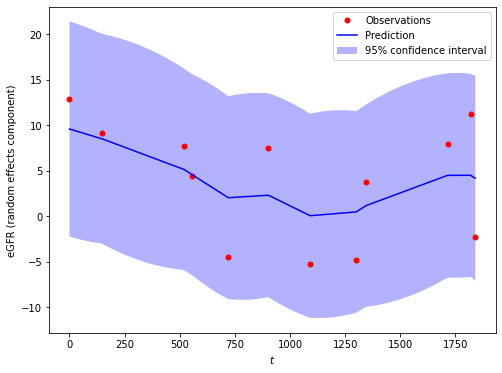

In [91]:
single_patient_data = data_train_full[data_train_full['ID'] == 1134]
y_true = single_patient_data['egfr'].to_numpy()
predictions = bst.predict(data=single_patient_data.drop(columns=['egfr', 'ID', 'times']), 
                          group_data_pred=single_patient_data['ID'],
                          gp_coords_pred=single_patient_data['times'],
                          cluster_ids_pred=single_patient_data['ID'],
                          predict_var=True)
points = np.arange(single_patient_data['times'].iloc[-1]+10, step=10)
p = np.tile(single_patient_data['ID'].iloc[0], len(points))
predictions_points = gp_model.predict(group_data_pred=p, gp_coords_pred=points, cluster_ids_pred=p, predict_var=True)
sigma = np.sqrt(predictions_points['var'])
plt.figure(figsize=(8,6))
plt.plot(single_patient_data['times'], y_true-predictions['fixed_effect'], 'r.', markersize=10, label='Observations')
plt.plot(points, predictions_points['mu'], 'b-', label='Prediction')
plt.fill_between(points, predictions_points['mu'] - 1.96 * sigma,
                 predictions_points['mu'] + 1.96 * sigma, alpha=0.3,
                 fc='b', label='95% confidence interval')
plt.xlabel('$t$')
plt.ylabel('eGFR (random effects component)')
plt.legend(loc='upper right')
plt.show()